<a href="https://colab.research.google.com/github/Muhammad-Abdullah-Jami/BERT-LLM/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

### Installing important libraries

In [ ]:
#!pip install datasets
#!pip install datasets pandas



In [ ]:
pip install transformers seaborn scikit-learn matplotlib


In [ ]:
import torch
print(torch.__version__)

2.3.1+cu121


### Importing libraries

In [ ]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Load the Yelp Reviews dataset

In [ ]:

# Load the Yelp Reviews Polarity dataset
dataset = load_dataset("yelp_polarity")

# Convert the training dataset to a pandas DataFrame for better visualization
df = pd.DataFrame({
    'label': dataset['train']['label'],
    'text': dataset['train']['text']
})

# Show the first few entries of the DataFrame
print(df.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

   label                                               text
0      0  Unfortunately, the frustration of being Dr. Go...
1      1  Been going to Dr. Goldberg for over 10 years. ...
2      0  I don't know what Dr. Goldberg was like before...
3      0  I'm writing this review to give you a heads up...
4      1  All the food is great here. But the best thing...


### EDA

In [ ]:
# Basic statistics
print("Dataset size:", df.shape)
print("Class distribution:\n", df['label'].value_counts())
print("Checking the Null Values:\n")
print(df.isnull().sum())
df.describe()


Dataset size: (560000, 2)
Class distribution:
 label
0    280000
1    280000
Name: count, dtype: int64
Checking the Null Values:

label    0
text     0
dtype: int64


,label
count,560000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


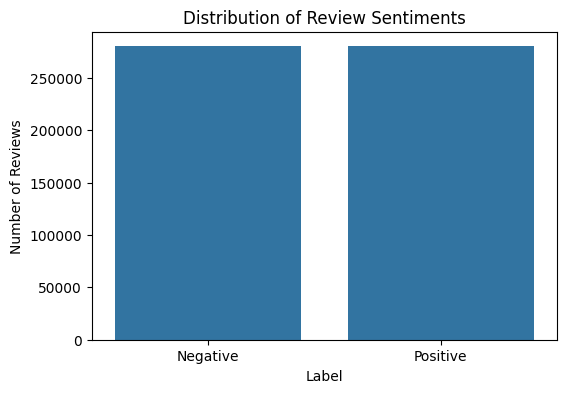

In [ ]:
# Plotting the distribution of reviews
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Label')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

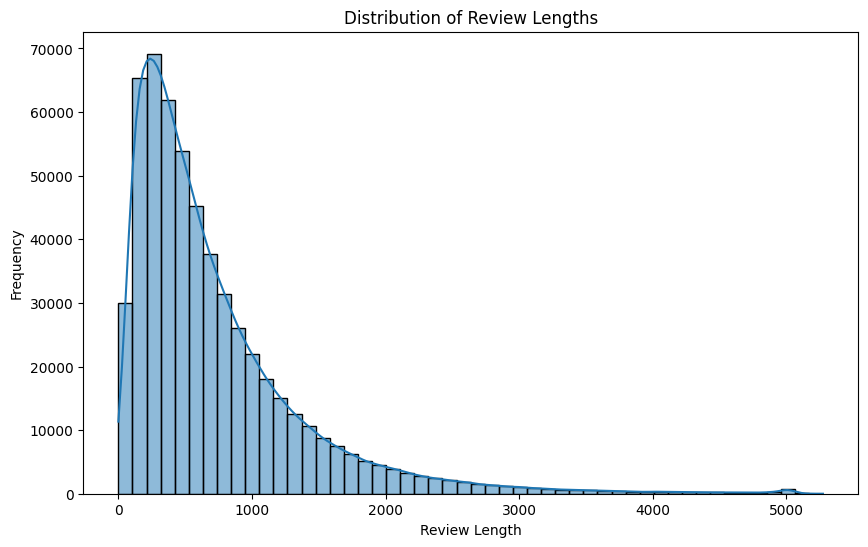

In [ ]:

# Adding a new column for review length
df['review_length'] = df['text'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

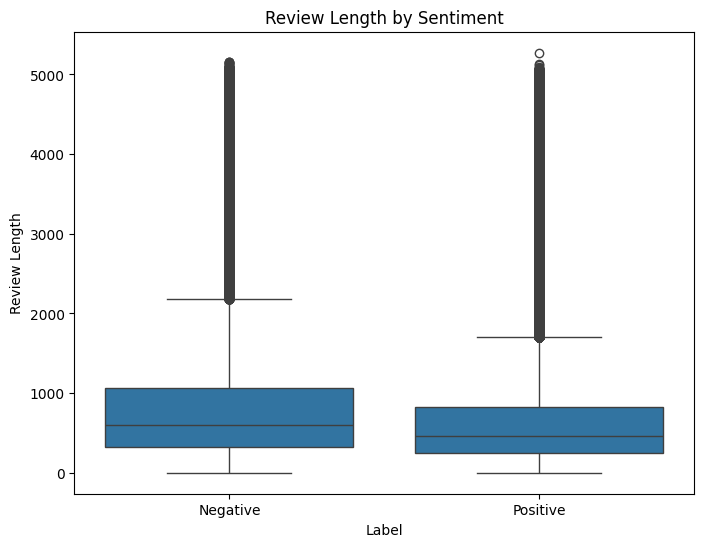

In [ ]:

# Boxplot to visualize the distribution of review lengths by label
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Label')
plt.ylabel('Review Length')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


### Applying the preprocessing techniques
### Making dataset ready for the Bert Model

In [ ]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode the data
def encode_data(texts, labels, max_len=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_data = tokenizer.encode_plus(
            text,
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
            max_length=max_len,            # Pad & truncate all sentences.
            padding='max_length',
            return_attention_mask=True,    # Construct attn. masks.
            return_tensors='pt',           # Return pytorch tensors.
            truncation=True
        )
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Sample data
texts = df['text'].tolist()
labels = df['label'].tolist()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:

# Split data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Encode data
train_inputs, train_masks, train_labels = encode_data(train_texts, train_labels)
validation_inputs, validation_masks, val_labels = encode_data(val_texts, val_labels)

# Create the DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

def train_model(model, train_dataloader, val_dataloader, optimizer, epochs=4):
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        predictions, true_vals = [], []

        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}

            model.zero_grad()
            outputs = model(**inputs)

            loss = outputs[0]
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            logits = outputs[1].detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_vals.extend(label_ids.flatten())

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = accuracy_score(true_vals, predictions)
        epoch_f1 = f1_score(true_vals, predictions, average='weighted')

        print(f'\nEpoch {epoch + 1}')
        print(f'Loss: {epoch_loss:.4f}')
        print(f'Accuracy: {epoch_acc:.4f}')
        print(f'F1 Score: {epoch_f1:.4f}')

        # Validation step
        eval_accuracy, eval_f1 = evaluate(model, val_dataloader)
        print(f'Validation Accuracy: {eval_accuracy:.4f}')
        print(f'Validation F1 Score: {eval_f1:.4f}')

def evaluate(model, dataloader):
    model.eval()
    predictions, true_vals = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_vals.extend(label_ids.flatten())

    accuracy = accuracy_score(true_vals, predictions)
    f1 = f1_score(true_vals, predictions, average='weighted')
    return accuracy, f1

# Call the train model function
train_model(model, train_dataloader, validation_dataloader, optimizer, epochs=4)


### Plotting the Confusion Matrix and Loss Curve

In [ ]:
# Assume you have recorded epoch_loss and epoch_accuracy in lists
sns.lineplot(x=range(1, 5), y=epoch_losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot confusion matrix
cf_matrix = confusion_matrix(true_vals, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Saving model paramters

In [ ]:
# Save the model's state dictionary
model_path = "bert_finetuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


### Saving entire model

In [ ]:
# Save the entire model
model_path_full = "bert_finetuned_full.pth"
torch.save(model, model_path_full)
print(f"Full model saved to {model_path_full}")


### Downloading the saved model

In [ ]:
# Save the model's state dictionary
model_path = "/content/bert_finetuned.pth"
torch.save(model.state_dict(), model_path)
from google.colab import files

# Download the file to your local computer
files.download('/content/bert_finetuned.pth')
